In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from tqdm import tqdm_notebook
from sklearn import tree
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_decision_regions

CLASS_NAMES=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'synth_lead', 'vocal']

SOURCE_NAMES=['acoustic', 'electronic', 'synthetic']
DATA_GROUPS=['test', 'valid', 'train']
FEATURE_LIST=['y_harmonic', 'y_percussive', 'chroma_cens', 'mfcc','mel_spec', 'spec_contrast']

def getDataset(dataGroup, source, target, other):#, instrument, source):
    
    new_dir='Dataset/nsynth-'+dataGroup+'/audio/'     #set the audio directory (test, train, etc)
    dataframe_raw = pd.read_json(path_or_buf='Dataset/nsynth-'+dataGroup+'/examples.json', orient='index') #read all instruments from examples.json
    dataframe_specific = dataframe_raw.loc[(dataframe_raw['instrument_family_str'] == target) | (dataframe_raw['instrument_family_str'] == other)]           #narrow down by family (strings, etc)
    dataframe_specific = dataframe_specific.loc[dataframe_specific['instrument_source_str'] == source]     #narrow down by source (acoustic, etc)

   
    Y = dataframe_specific.instrument_family_str.replace(to_replace=[other, target], value=[0, 1])
    filenames = dataframe_specific.index.tolist()     #get filenames from our dataframe, put into list
    
    dictionary = {}
    for file in tqdm_notebook(filenames):             #for all files in filenames. Also,  tqdm is a loading bar
       # print(new_dir)
       # print(file)
       # print('.wav')
       # print(new_dir+file+'.wav')
        features = feature_extract((new_dir+file+'.wav')) #specify directory, file, then add .wav. we will perform feature_extract with the file
        dictionary[file] = features                       #make dictionary using file as rows - features as columns
    featureDf = pd.DataFrame.from_dict(dictionary, orient='index', #turn into dataframe
                                       columns=FEATURE_LIST)
    featureFinal = pd.concat([dataframe_specific, featureDf], axis=1, sort=False)

    featureFinal['targetValue'] = Y
    return featureFinal #returns dataframe of features

def feature_extract(file):
    y, sr = librosa.load(file, sr=None)
    
    hop_length = 512
    
    # Separate harmonics and percussives into two waveforms
    y_harmonic, y_percussive = librosa.effects.hpss(y)    

    #Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, 
                                                 fmax = 8000)
    #Mel-Frequency Cepstral Coefficients (MFCC) features from the raw signal
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
    
    #Spectral Contrast
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    
    y_harmonic = np.mean(y_harmonic)
    y_percussive = np.mean(y_percussive)
    mel_spec = np.mean(mel_spec)
    mfcc = np.mean(mfcc, axis =1)
    chroma_cens = np.mean(chroma_cens)
    spec_contrast = np.mean(spec_contrast)
    
    return [y_harmonic, y_percussive, chroma_cens, mfcc, mel_spec, 
            spec_contrast]

In [2]:
#prediction,accuracy = runSVM()
dataGroup = DATA_GROUPS[0]    #SET IF YOU WANT TEST, TRAIN, OR VALID (IF YOU HAVE IT)
instrumentTarget = CLASS_NAMES[8]   #SET THE INSTRUMENT YOU WANT
source = SOURCE_NAMES[0]      #SET ACOUSTIC, ELECTRONIC, SYNTHETIC
instrumentOther = CLASS_NAMES[4]

test = pd.read_csv("test.csv")

dataGroup = DATA_GROUPS[2]    #SET IF YOU WANT TEST, TRAIN, OR VALID (IF YOU HAVE IT)
instrumentTarget = CLASS_NAMES[8]   #SET THE INSTRUMENT YOU WANT
source = SOURCE_NAMES[0]      #SET ACOUSTIC, ELECTRONIC, SYNTHETIC
instrumentOther = CLASS_NAMES[4]

train = pd.read_csv("train.csv")

def equalize_data(dataFrame, instrument, other):
    Df1 = dataFrame.loc[dataFrame['instrument_family_str']==instrument]
    Df2 = dataFrame.loc[dataFrame['instrument_family_str']==other]
    tempDf1 = Df1
    tempDf2 = Df2
    if (tempDf1['y_harmonic'].count() < tempDf2['y_harmonic'].count()):
        while (tempDf1['y_harmonic'].count()<tempDf2['y_harmonic'].count()): 
            temp = [tempDf1, Df1]
            tempDf2 = pd.concat(temp)
        tempDf2 = tempDf2[:tempDf1['y_harmonic'].count()]
    else:
        while (tempDf2['y_harmonic'].count()<tempDf1['y_harmonic'].count()):
            temp = [tempDf2, Df2]
            tempDf2 = pd.concat(temp)
        tempDf2 = tempDf2[:tempDf1['y_harmonic'].count()]
    returnDf = pd.concat([tempDf1, tempDf2])
    return (returnDf)



y_harmonic
[[ 0.16910191  4.21339798]
 [ 0.20158149  5.74186087]
 [ 0.18092075  1.3231045 ]
 ...
 [ 0.17477854  2.50405812]
 [ 0.15904257 13.63728428]
 [ 0.17983005  0.16605109]]
[1 1 0 ... 0 1 1]
(38780, 2)
(38780,)
[[ 0.16910191  4.21339798]
 [ 0.20158149  5.74186087]
 [ 0.18092075  1.3231045 ]
 ...
 [ 0.17477854  2.50405812]
 [ 0.15904257 13.63728428]
 [ 0.17983005  0.16605109]]
[1 1 0 ... 0 1 1]
(612, 2)
[1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1
 0 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0
 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 0 0
 0 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 

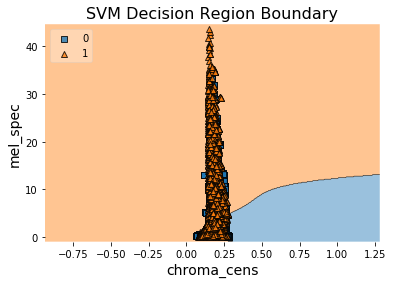

In [12]:
test = equalize_data(test, CLASS_NAMES[8], CLASS_NAMES[4])
train = equalize_data(train, CLASS_NAMES[8], CLASS_NAMES[4])

train = train.sample(frac=1)
test = test.sample(frac=1)


for x in range(1):
    print(FEATURE_LIST[x])
    testX = test.drop(['targetValue'], axis=1)
    testX = test[['chroma_cens','mel_spec']]#'mfcc', 'mel_spec', 'spec_contrast']]    
    testY = test['targetValue'].values

    trainX = train[['chroma_cens','mel_spec']]##, 'y_percussive','chroma_cens', 'mfcc', 'mel_spec', 'spec_contrast']]
    trainY = train['targetValue'].values

    #testX = testX.apply(lambda x: x*10**4)
    #trainX = trainX.apply(lambda x: x*10**4)
    testX = testX.to_numpy()
    trainX = trainX.to_numpy()
    print(trainX)
    print(trainY)
     
    clf = svm.SVC(kernel='rbf', C=50, gamma=0.01)

    print(trainX.shape)
    print(trainY.shape)
    print(trainX)
    print(trainY)
    
    print(testX.shape)
    
    clf.fit(trainX, trainY)

    prediction = clf.predict(testX)
    accuracy = metrics.accuracy_score(testY, prediction)
    
    print(prediction)

    print("Accuracy ",FEATURE_LIST[x],": ", accuracy)
    print(confusion_matrix(testY,prediction))
    print(classification_report(testY,prediction))
    
    plot_decision_regions(X=trainX, 
                      y=trainY,
                      clf=clf, 
                      legend=2)
    plt.xlabel('chroma_cens', size=14)
    plt.ylabel('mel_spec', size=14)
    plt.title('SVM Decision Region Boundary', size=16)
    plt.show()
    
    
    

In [ ]:
for x in range(6):
    print(FEATURE_LIST[x])
    testX = test.drop(['targetValue'], axis=1)
    testX = test[[FEATURE_LIST[x]]]#,'y_percussive', 'chroma_cens','mfcc', 'mel_spec', 'spec_contrast']]    
    testY = test['targetValue'].values

    trainX = train[[FEATURE_LIST[x]]]#, 'y_percussive','chroma_cens', 'mfcc', 'mel_spec', 'spec_contrast']]
    trainY = train['targetValue'].values

    #testX = testX.apply(lambda x: x*10**4)
    #trainX = trainX.apply(lambda x: x*10**4)
    testX = testX.to_numpy()
    trainX = trainX.to_numpy()
    print(trainX)
    print(trainY)
     
    clf = svm.SVC(kernel='linear')

    print(trainX.shape)
    print(trainY.shape)
    print(trainX)
    print(trainY)
    
    print(testX.shape)
    
    clf.fit(trainX, trainY)

    prediction = clf.predict(testX)
    accuracy = metrics.accuracy_score(testY, prediction)
    
    print(prediction)

    print("Accuracy ",FEATURE_LIST[x],": ", accuracy)
    print(confusion_matrix(testY,prediction))
    print(classification_report(testY,prediction))
    
    plot_decision_regions(X=trainX, 
                      y=trainY,
                      clf=clf, 
                      legend=2)
    plt.xlabel('y_harmonic', 'chroma_cens', size=14)
    #plt.ylabel('chroma_cens', size=14)
    plt.title('SVM Decision Region Boundary', size=16)

In [ ]:
print(FEATURE_LIST[x])
    testX = test.drop(['targetValue'], axis=1)
    testX = test[FEATURE_LIST[x]]#,'y_percussive', 'chroma_cens','mfcc', 'mel_spec', 'spec_contrast']]    
    testY = test['targetValue'].values

    trainX = train[FEATURE_LIST[x]]#, 'y_percussive','chroma_cens', 'mfcc', 'mel_spec', 'spec_contrast']]
    trainY = train['targetValue'].values

    testX = testX.apply(lambda x: x*10**4)
    trainX = trainX.apply(lambda x: x*10**4)
    testX = testX.to_numpy()
    trainX = trainX.to_numpy()
    print(trainX)
    print(trainY)
     
    clf = svm.SVC(kernel='linear')

    print(trainX.shape)
    print(trainY.shape)
    print(trainX)
    print(trainY)
    
    print(testX.shape)
    
    clf.fit(trainX, trainY)

    prediction = clf.predict(testX)
    accuracy = metrics.accuracy_score(testY, prediction)
    
    print(prediction)

    print("Accuracy ",FEATURE_LIST[x],": ", accuracy)
    print(confusion_matrix(testY,prediction))
    print(classification_report(testY,prediction))
    
    plot_decision_regions(X=trainX, 
                      y=trainY,
                      clf=clf, 
                      legend=2)
    plt.xlabel('y_harmonic', 'chroma_cens', size=14)
    #plt.ylabel('chroma_cens', size=14)
    plt.title('SVM Decision Region Boundary', size=16)